In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import math

df = pd.read_csv('dataset/day_wise.csv')

In [9]:

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['New cases']].copy()

In [11]:

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(data_scaled, window_size)


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0589  
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0444
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014    
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 16/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s

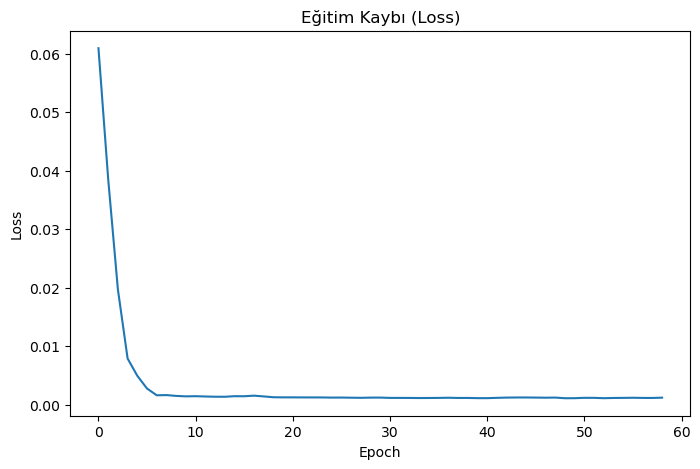

In [13]:

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, callbacks=[early_stop])

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.title('Eğitim Kaybı (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Test MSE: 748995426.350335
Test RMSE: 27367.780807919647


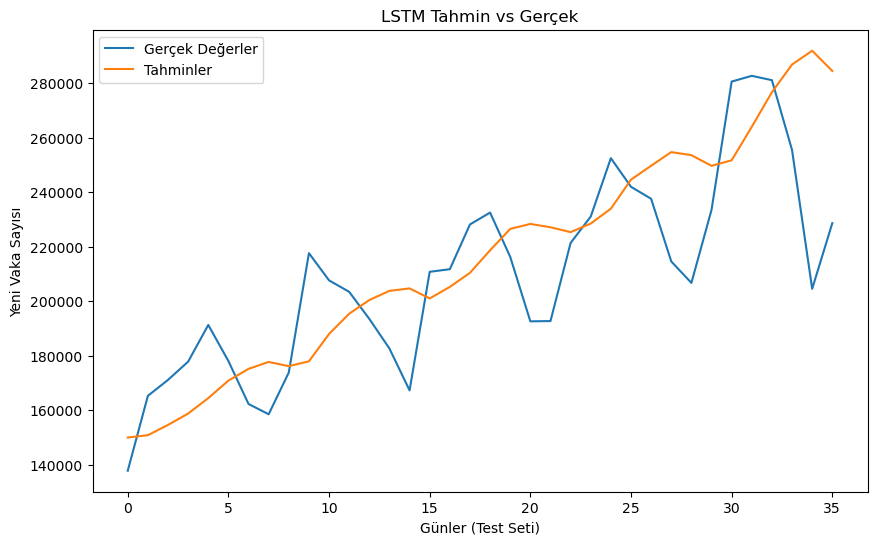

In [15]:

y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mse)
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")

# Tahmin ve Gerçek değer görselleştirme
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Gerçek Değerler')
plt.plot(y_pred_inv, label='Tahminler')
plt.title('LSTM Tahmin vs Gerçek')
plt.xlabel('Günler (Test Seti)')
plt.ylabel('Yeni Vaka Sayısı')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


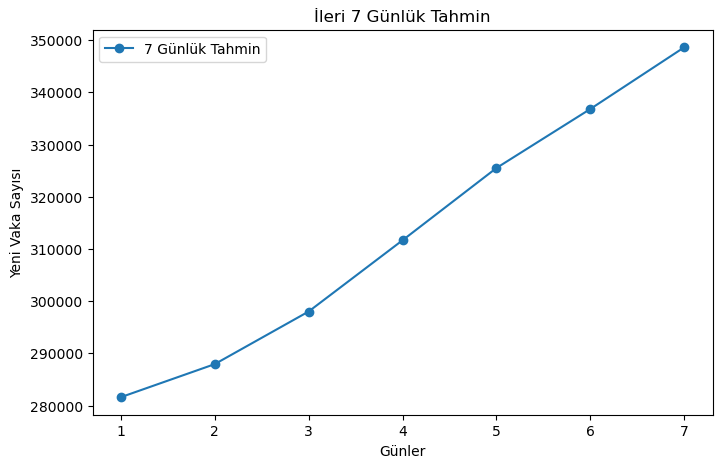

In [17]:

future_predictions = []
current_batch = data_scaled[-window_size:].reshape((1, window_size, 1))

for i in range(7):
    pred = model.predict(current_batch)[0]
    future_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:], [[pred]], axis=1)

future_predictions_inv = scaler.inverse_transform(future_predictions)

plt.figure(figsize=(8,5))
plt.plot(range(1,8), future_predictions_inv, marker='o', label='7 Günlük Tahmin')
plt.title('İleri 7 Günlük Tahmin')
plt.xlabel('Günler')
plt.ylabel('Yeni Vaka Sayısı')
plt.legend()
plt.show()

In [23]:
from tensorflow.keras.losses import MeanSquaredError

model.compile(optimizer='adam', loss=MeanSquaredError())
model.save('covid_lstm_cnn_model.h5')
np.save('scaler_min.npy', scaler.min_)
np.save('scaler_scale.npy', scaler.scale_)

print("Model ve scaler kaydedildi.")


Model ve scaler kaydedildi.
